# 3 layer LSTM Encoder Decoder, dropout. 30 day input, 7 day forecast

In [127]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
save_dir = 'models/lstm4.6'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
data = df.values

In [60]:
num_input = 120
num_out = 3
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (568, 120, 25)
train_y shape (568, 3, 1)
dev_X shape (71, 120, 25)
dev_y shape (71, 3, 1)
test_X shape (72, 120, 25)
test_y shape (72, 3, 1)
train_y_acc shape (568, 3, 1)
dev_y_acc shape (71, 3, 1)
test_y_acc shape (72, 3, 1)


In [96]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0005
decay = 1e-6
dropout_rate = 0.3
epochs = 1000
batch_size = 32

model = Sequential()
model.add(CuDNNLSTM(200, input_shape=input_shape))
model.add(Dropout(dropout_rate))
model.add(RepeatVector(num_out))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 200)               181600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 3, 200)            0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 3, 200)            321600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 200)            0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 3, 100)            20100     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 3, 1)              101       
Total para

In [97]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 1000 epochs, 32 batch size
Train on 568 samples, validate on 71 samples
Epoch 1/1000
568/568 [==============================] - 1s 2ms/step - loss: 0.0371 - val_loss: 0.0211
Epoch 2/1000
568/568 [==============================] - 1s 974us/step - loss: 0.0129 - val_loss: 0.0090
Epoch 3/1000
568/568 [==============================] - 1s 953us/step - loss: 0.0057 - val_loss: 0.0033
Epoch 4/1000
568/568 [==============================] - 1s 956us/step - loss: 0.0034 - val_loss: 0.0030
Epoch 5/1000
568/568 [==============================] - 1s 954us/step - loss: 0.0028 - val_loss: 0.0018
Epoch 6/1000
568/568 [==============================] - 1s 953us/step - loss: 0.0032 - val_loss: 0.0020
Epoch 7/1000
568/568 [==============================] - 1s 966us/step - loss: 0.0031 - val_loss: 0.0040
Epoch 8/1000
568/568 [==============================] - 1s 957us/step - loss: 0.0026 - val_loss: 0.0013
Epoch 9/1000
568/568 [==============================] - 1s 955us/

Epoch 77/1000
568/568 [==============================] - 1s 961us/step - loss: 8.6595e-04 - val_loss: 9.5248e-04
Epoch 78/1000
568/568 [==============================] - 1s 952us/step - loss: 9.6255e-04 - val_loss: 0.0010
Epoch 79/1000
568/568 [==============================] - 1s 952us/step - loss: 9.6257e-04 - val_loss: 9.0620e-04
Epoch 80/1000
568/568 [==============================] - 1s 959us/step - loss: 7.8787e-04 - val_loss: 8.0886e-04
Epoch 81/1000
568/568 [==============================] - 1s 958us/step - loss: 9.9165e-04 - val_loss: 9.4521e-04
Epoch 82/1000
568/568 [==============================] - 1s 955us/step - loss: 8.5584e-04 - val_loss: 0.0011
Epoch 83/1000
568/568 [==============================] - 1s 951us/step - loss: 8.1034e-04 - val_loss: 0.0011
Epoch 84/1000
568/568 [==============================] - 1s 968us/step - loss: 8.2309e-04 - val_loss: 0.0010
Epoch 85/1000
568/568 [==============================] - 1s 963us/step - loss: 8.7563e-04 - val_loss: 8.1001e-04

568/568 [==============================] - 1s 957us/step - loss: 6.6520e-04 - val_loss: 0.0010
Epoch 150/1000
568/568 [==============================] - 1s 961us/step - loss: 7.0737e-04 - val_loss: 7.0180e-04
Epoch 151/1000
568/568 [==============================] - 1s 952us/step - loss: 6.1221e-04 - val_loss: 7.5240e-04
Epoch 152/1000
568/568 [==============================] - 1s 955us/step - loss: 6.2260e-04 - val_loss: 8.7816e-04
Epoch 153/1000
568/568 [==============================] - 1s 954us/step - loss: 7.3277e-04 - val_loss: 7.2454e-04
Epoch 154/1000
568/568 [==============================] - 1s 961us/step - loss: 6.3704e-04 - val_loss: 6.3234e-04
Epoch 155/1000
568/568 [==============================] - 1s 963us/step - loss: 6.4397e-04 - val_loss: 7.6107e-04
Epoch 156/1000
568/568 [==============================] - 1s 961us/step - loss: 6.9945e-04 - val_loss: 8.6737e-04
Epoch 157/1000
568/568 [==============================] - 1s 952us/step - loss: 7.1607e-04 - val_loss: 5.52

568/568 [==============================] - 1s 953us/step - loss: 6.8699e-04 - val_loss: 6.1602e-04
Epoch 222/1000
568/568 [==============================] - 1s 957us/step - loss: 5.9606e-04 - val_loss: 5.5385e-04
Epoch 223/1000
568/568 [==============================] - 1s 956us/step - loss: 5.7029e-04 - val_loss: 5.8096e-04
Epoch 224/1000
568/568 [==============================] - 1s 960us/step - loss: 5.0178e-04 - val_loss: 4.8055e-04
Epoch 225/1000
568/568 [==============================] - 1s 963us/step - loss: 4.8766e-04 - val_loss: 5.6553e-04
Epoch 226/1000
568/568 [==============================] - 1s 955us/step - loss: 5.1317e-04 - val_loss: 6.3890e-04
Epoch 227/1000
568/568 [==============================] - 1s 958us/step - loss: 5.0304e-04 - val_loss: 4.8926e-04
Epoch 228/1000
568/568 [==============================] - 1s 956us/step - loss: 5.3799e-04 - val_loss: 4.3345e-04
Epoch 229/1000
568/568 [==============================] - 1s 948us/step - loss: 5.0607e-04 - val_loss: 

568/568 [==============================] - 1s 964us/step - loss: 4.8073e-04 - val_loss: 3.7591e-04
Epoch 294/1000
568/568 [==============================] - 1s 959us/step - loss: 3.8102e-04 - val_loss: 4.3542e-04
Epoch 295/1000
568/568 [==============================] - 1s 960us/step - loss: 4.1018e-04 - val_loss: 3.8257e-04
Epoch 296/1000
568/568 [==============================] - 1s 967us/step - loss: 3.9082e-04 - val_loss: 4.0440e-04
Epoch 297/1000
568/568 [==============================] - 1s 963us/step - loss: 4.0265e-04 - val_loss: 3.5093e-04
Epoch 298/1000
568/568 [==============================] - 1s 956us/step - loss: 3.9278e-04 - val_loss: 3.7220e-04
Epoch 299/1000
568/568 [==============================] - 1s 956us/step - loss: 4.8105e-04 - val_loss: 4.6947e-04
Epoch 300/1000
568/568 [==============================] - 1s 952us/step - loss: 3.7464e-04 - val_loss: 3.5715e-04
Epoch 301/1000
568/568 [==============================] - 1s 957us/step - loss: 4.1012e-04 - val_loss: 

Epoch 365/1000
568/568 [==============================] - 1s 967us/step - loss: 3.5342e-04 - val_loss: 4.4820e-04
Epoch 366/1000
568/568 [==============================] - 1s 963us/step - loss: 3.4026e-04 - val_loss: 4.5124e-04
Epoch 367/1000
568/568 [==============================] - 1s 953us/step - loss: 3.2537e-04 - val_loss: 2.9440e-04
Epoch 368/1000
568/568 [==============================] - 1s 952us/step - loss: 3.0752e-04 - val_loss: 3.4333e-04
Epoch 369/1000
568/568 [==============================] - 1s 956us/step - loss: 3.3278e-04 - val_loss: 4.1444e-04
Epoch 370/1000
568/568 [==============================] - 1s 956us/step - loss: 3.5386e-04 - val_loss: 2.8826e-04
Epoch 371/1000
568/568 [==============================] - 1s 963us/step - loss: 3.4926e-04 - val_loss: 3.2812e-04
Epoch 372/1000
568/568 [==============================] - 1s 956us/step - loss: 3.1440e-04 - val_loss: 3.1639e-04
Epoch 373/1000
568/568 [==============================] - 1s 966us/step - loss: 3.5015e-

Epoch 437/1000
568/568 [==============================] - 1s 948us/step - loss: 3.4521e-04 - val_loss: 3.4843e-04
Epoch 438/1000
568/568 [==============================] - 1s 952us/step - loss: 3.4193e-04 - val_loss: 3.1323e-04
Epoch 439/1000
568/568 [==============================] - 1s 959us/step - loss: 3.1576e-04 - val_loss: 3.5146e-04
Epoch 440/1000
568/568 [==============================] - 1s 957us/step - loss: 3.1870e-04 - val_loss: 4.0330e-04
Epoch 441/1000
568/568 [==============================] - 1s 953us/step - loss: 3.9670e-04 - val_loss: 4.0822e-04
Epoch 442/1000
568/568 [==============================] - 1s 958us/step - loss: 4.0439e-04 - val_loss: 4.2008e-04
Epoch 443/1000
568/568 [==============================] - 1s 969us/step - loss: 3.1159e-04 - val_loss: 3.6968e-04
Epoch 444/1000
568/568 [==============================] - 1s 962us/step - loss: 2.6594e-04 - val_loss: 2.9602e-04
Epoch 445/1000
568/568 [==============================] - 1s 968us/step - loss: 2.7583e-

Epoch 509/1000
568/568 [==============================] - 1s 959us/step - loss: 2.7823e-04 - val_loss: 2.5835e-04
Epoch 510/1000
568/568 [==============================] - 1s 955us/step - loss: 2.8210e-04 - val_loss: 2.9355e-04
Epoch 511/1000
568/568 [==============================] - 1s 955us/step - loss: 2.7871e-04 - val_loss: 4.5121e-04
Epoch 512/1000
568/568 [==============================] - 1s 961us/step - loss: 2.9776e-04 - val_loss: 2.8761e-04
Epoch 513/1000
568/568 [==============================] - 1s 961us/step - loss: 3.2071e-04 - val_loss: 3.0351e-04
Epoch 514/1000
568/568 [==============================] - 1s 957us/step - loss: 2.8379e-04 - val_loss: 3.0507e-04
Epoch 515/1000
568/568 [==============================] - 1s 957us/step - loss: 2.9368e-04 - val_loss: 3.7499e-04
Epoch 516/1000
568/568 [==============================] - 1s 962us/step - loss: 2.7015e-04 - val_loss: 3.1827e-04
Epoch 517/1000
568/568 [==============================] - 1s 961us/step - loss: 2.6019e-

Epoch 581/1000
568/568 [==============================] - 1s 964us/step - loss: 4.0367e-04 - val_loss: 4.9078e-04
Epoch 582/1000
568/568 [==============================] - 1s 968us/step - loss: 3.6092e-04 - val_loss: 2.9593e-04
Epoch 583/1000
568/568 [==============================] - 1s 958us/step - loss: 3.1923e-04 - val_loss: 3.2141e-04
Epoch 584/1000
568/568 [==============================] - 1s 953us/step - loss: 3.0008e-04 - val_loss: 3.1679e-04
Epoch 585/1000
568/568 [==============================] - 1s 958us/step - loss: 2.6851e-04 - val_loss: 2.8057e-04
Epoch 586/1000
568/568 [==============================] - 1s 960us/step - loss: 2.3661e-04 - val_loss: 2.4398e-04
Epoch 587/1000
568/568 [==============================] - 1s 956us/step - loss: 2.3133e-04 - val_loss: 2.6340e-04
Epoch 588/1000
568/568 [==============================] - 1s 956us/step - loss: 2.9725e-04 - val_loss: 3.2084e-04
Epoch 589/1000
568/568 [==============================] - 1s 965us/step - loss: 3.0407e-

Epoch 653/1000
568/568 [==============================] - 1s 957us/step - loss: 2.3494e-04 - val_loss: 2.4241e-04
Epoch 654/1000
568/568 [==============================] - 1s 967us/step - loss: 2.5858e-04 - val_loss: 3.0363e-04
Epoch 655/1000
568/568 [==============================] - 1s 963us/step - loss: 2.6054e-04 - val_loss: 2.3536e-04
Epoch 656/1000
568/568 [==============================] - 1s 960us/step - loss: 2.4298e-04 - val_loss: 3.2180e-04
Epoch 657/1000
568/568 [==============================] - 1s 952us/step - loss: 2.5173e-04 - val_loss: 3.6689e-04
Epoch 658/1000
568/568 [==============================] - 1s 951us/step - loss: 2.4724e-04 - val_loss: 2.7635e-04
Epoch 659/1000
568/568 [==============================] - 1s 962us/step - loss: 2.7183e-04 - val_loss: 2.5657e-04
Epoch 660/1000
568/568 [==============================] - 1s 967us/step - loss: 2.5365e-04 - val_loss: 3.0903e-04
Epoch 661/1000
568/568 [==============================] - 1s 962us/step - loss: 3.0559e-

Epoch 725/1000
568/568 [==============================] - 1s 964us/step - loss: 2.1193e-04 - val_loss: 2.0647e-04
Epoch 726/1000
568/568 [==============================] - 1s 958us/step - loss: 2.1631e-04 - val_loss: 2.4101e-04
Epoch 727/1000
568/568 [==============================] - 1s 964us/step - loss: 2.2910e-04 - val_loss: 3.3465e-04
Epoch 728/1000
568/568 [==============================] - 1s 958us/step - loss: 2.3843e-04 - val_loss: 2.4702e-04
Epoch 729/1000
568/568 [==============================] - 1s 957us/step - loss: 2.1599e-04 - val_loss: 2.1116e-04
Epoch 730/1000
568/568 [==============================] - 1s 958us/step - loss: 2.0840e-04 - val_loss: 2.3564e-04
Epoch 731/1000
568/568 [==============================] - 1s 957us/step - loss: 2.0851e-04 - val_loss: 2.7950e-04
Epoch 732/1000
568/568 [==============================] - 1s 957us/step - loss: 2.2839e-04 - val_loss: 2.4453e-04
Epoch 733/1000
568/568 [==============================] - 1s 960us/step - loss: 2.2393e-

Epoch 797/1000
568/568 [==============================] - 1s 959us/step - loss: 2.3493e-04 - val_loss: 2.4330e-04
Epoch 798/1000
568/568 [==============================] - 1s 954us/step - loss: 2.1596e-04 - val_loss: 2.3373e-04
Epoch 799/1000
568/568 [==============================] - 1s 961us/step - loss: 2.0963e-04 - val_loss: 2.1074e-04
Epoch 800/1000
568/568 [==============================] - 1s 960us/step - loss: 1.7789e-04 - val_loss: 2.1798e-04
Epoch 801/1000
568/568 [==============================] - 1s 950us/step - loss: 1.8948e-04 - val_loss: 2.7054e-04
Epoch 802/1000
568/568 [==============================] - 1s 955us/step - loss: 2.4018e-04 - val_loss: 2.6676e-04
Epoch 803/1000
568/568 [==============================] - 1s 963us/step - loss: 2.3325e-04 - val_loss: 2.3656e-04
Epoch 804/1000
568/568 [==============================] - 1s 951us/step - loss: 2.1577e-04 - val_loss: 2.4144e-04
Epoch 805/1000
568/568 [==============================] - 1s 960us/step - loss: 2.4016e-

Epoch 869/1000
568/568 [==============================] - 1s 960us/step - loss: 1.9779e-04 - val_loss: 2.0687e-04
Epoch 870/1000
568/568 [==============================] - 1s 956us/step - loss: 1.8666e-04 - val_loss: 1.9602e-04
Epoch 871/1000
568/568 [==============================] - 1s 949us/step - loss: 2.1140e-04 - val_loss: 2.7863e-04
Epoch 872/1000
568/568 [==============================] - 1s 956us/step - loss: 2.4196e-04 - val_loss: 2.2734e-04
Epoch 873/1000
568/568 [==============================] - 1s 956us/step - loss: 2.5970e-04 - val_loss: 2.7796e-04
Epoch 874/1000
568/568 [==============================] - 1s 958us/step - loss: 2.4952e-04 - val_loss: 2.4078e-04
Epoch 875/1000
568/568 [==============================] - 1s 961us/step - loss: 2.0036e-04 - val_loss: 2.4900e-04
Epoch 876/1000
568/568 [==============================] - 1s 960us/step - loss: 1.8472e-04 - val_loss: 2.0063e-04
Epoch 877/1000
568/568 [==============================] - 1s 951us/step - loss: 1.9732e-

Epoch 941/1000
568/568 [==============================] - 1s 955us/step - loss: 1.8498e-04 - val_loss: 1.6858e-04
Epoch 942/1000
568/568 [==============================] - 1s 963us/step - loss: 1.7052e-04 - val_loss: 1.8746e-04
Epoch 943/1000
568/568 [==============================] - 1s 965us/step - loss: 1.7188e-04 - val_loss: 1.8453e-04
Epoch 944/1000
568/568 [==============================] - 1s 960us/step - loss: 1.8509e-04 - val_loss: 2.2234e-04
Epoch 945/1000
568/568 [==============================] - 1s 957us/step - loss: 1.8302e-04 - val_loss: 1.9087e-04
Epoch 946/1000
568/568 [==============================] - 1s 955us/step - loss: 1.9108e-04 - val_loss: 2.2311e-04
Epoch 947/1000
568/568 [==============================] - 1s 959us/step - loss: 2.0285e-04 - val_loss: 2.0381e-04
Epoch 948/1000
568/568 [==============================] - 1s 956us/step - loss: 1.6727e-04 - val_loss: 1.9310e-04
Epoch 949/1000
568/568 [==============================] - 1s 960us/step - loss: 1.8443e-

In [98]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.00010117399174282208
MSE Dev: 0.0001966789350075575
MSE Test: 0.0006727154813755629


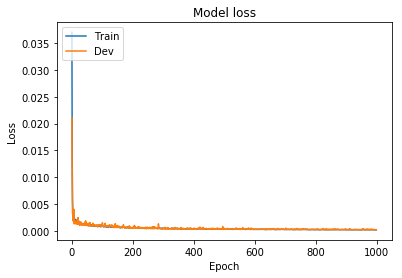

In [99]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()

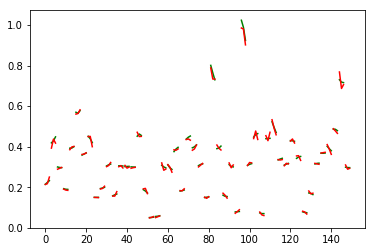

In [106]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_train.tolist()[:50], [], num_out, baseline_data=true_train.tolist()[:50])

# predicted_train = model.predict(train_X).squeeze()
# predicted_train = predicted_train[:, 0].reshape(-1,1)
# true_train = train_y[:, 0].reshape(-1,1)
# utils.plot_results(predicted_train[:50], true_train[:50])

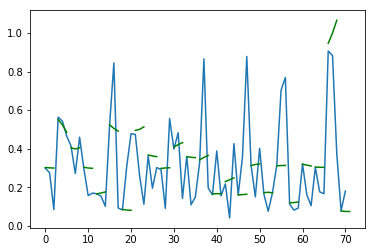

(24, 3)


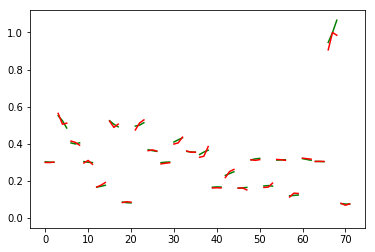

In [107]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_dev.tolist(), true_dev, num_out)
true_dev = dev_y[::num_out].squeeze()
print(true_dev.shape)
utils.plot_results_multiple(predicted_dev.tolist(), [0], num_out, baseline_data=true_dev.tolist())

# predicted_dev = model.predict(dev_X).squeeze()
# predicted_dev = predicted_dev[:, 0].reshape(-1,1)
# true_dev = dev_y[:, 0].reshape(-1,1)
# utils.plot_results(predicted_dev, true_dev)

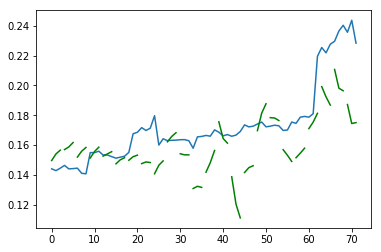

In [120]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

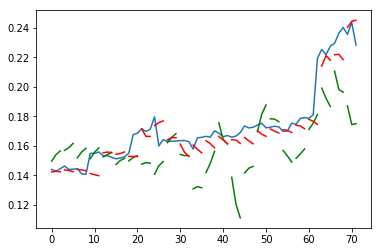

VAR MAE Test: 0.006268360850868079
LSTM MAE Test: 0.018131591976242714


In [129]:
var_preds = utils.var_predict(test_X[:, :, 0:5], num_out)
var_preds = var_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=var_preds.tolist())

print("VAR MAE Test:", mean_absolute_error(var_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



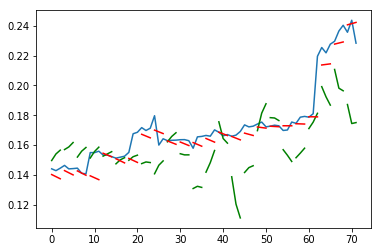

ARIMA MAE Test: 0.005254289577884629
LSTM MAE Test: 0.018131591976242714


In [128]:
arima_preds = utils.arima_predict(test_X[:, :, 0], num_out)
arima_preds = arima_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=arima_preds.tolist())

print("ARIMA MAE Test:", mean_absolute_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

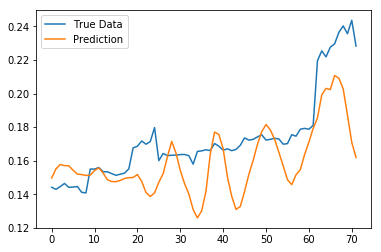

In [110]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[:, 0].reshape(-1,1)
true_test = test_y[:, 0].reshape(-1,1)
utils.plot_results(predicted_test, true_test)

In [85]:
print("MSE Train:", mean_squared_error(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("MSE Test:", mean_squared_error(predicted_test.reshape(-1,1)[:len(true_test)], true_test))
print("MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

MSE Train: 0.0001414338277576649
MSE Dev: 0.00022182895702165412
MSE Test: 0.0006808385456666952
MAE Test: 0.021197578116983497


In [18]:
print("Acc Train:", utils.direction_accuracy(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("Acc Dev:", utils.direction_accuracy(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("Acc Test:", utils.direction_accuracy(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

Acc Train: 0.8606701940035273
Acc Dev: 0.5285714285714286
Acc Test: 0.5070422535211268


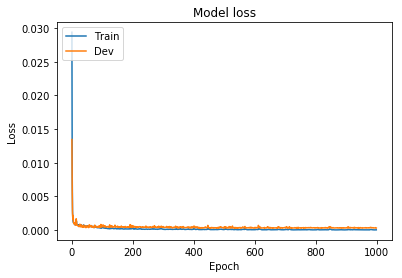

In [29]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()